In [1]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F

s=10
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [2]:
# data wrangling: load MNIST
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


MNIST_train = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=True,
        download=True,
        transform=MNIST_transform)


MNIST_test = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform)


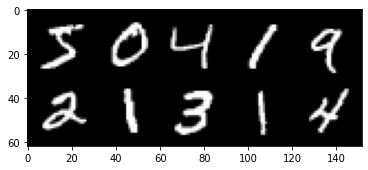

In [3]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = MNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))


In [5]:
mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=128,
    shuffle=True
)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [6]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)


In [7]:
#set up the training routine
mnist_model = NN(num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()

mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
MNIST_PATH = "MNIST_weights_seed={}.pth".format(s)
#print(MNIST_PATH)

In [8]:
# helper function to get accuracy
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()


In [8]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(mnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(mnist_train_loader):
            output = mnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            mnist_train_optimizer.step()
            mnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(MNIST_PATH))
    torch.save(mnist_model.state_dict(), MNIST_PATH)

In [9]:
#after training it once, comment this out to save time if you rerun the entire script
train(verbose=True, num_iter=5)


Iteration 0; 0/469 	Minibatch Loss 2.305  Accuracy 6%
Iteration 0; 10/469 	Minibatch Loss 1.870  Accuracy 62%
Iteration 0; 20/469 	Minibatch Loss 1.099  Accuracy 75%
Iteration 0; 30/469 	Minibatch Loss 0.672  Accuracy 82%
Iteration 0; 40/469 	Minibatch Loss 0.375  Accuracy 91%
Iteration 0; 50/469 	Minibatch Loss 0.398  Accuracy 89%
Iteration 0; 60/469 	Minibatch Loss 0.309  Accuracy 90%
Iteration 0; 70/469 	Minibatch Loss 0.283  Accuracy 92%
Iteration 0; 80/469 	Minibatch Loss 0.195  Accuracy 94%
Iteration 0; 90/469 	Minibatch Loss 0.319  Accuracy 90%
Iteration 0; 100/469 	Minibatch Loss 0.266  Accuracy 94%
Iteration 0; 110/469 	Minibatch Loss 0.301  Accuracy 93%
Iteration 0; 120/469 	Minibatch Loss 0.278  Accuracy 91%
Iteration 0; 130/469 	Minibatch Loss 0.229  Accuracy 94%
Iteration 0; 140/469 	Minibatch Loss 0.150  Accuracy 96%
Iteration 0; 150/469 	Minibatch Loss 0.135  Accuracy 95%
Iteration 0; 160/469 	Minibatch Loss 0.110  Accuracy 97%
Iteration 0; 170/469 	Minibatch Loss 0.208 

Iteration 3; 40/469 	Minibatch Loss 0.042  Accuracy 98%
Iteration 3; 50/469 	Minibatch Loss 0.050  Accuracy 99%
Iteration 3; 60/469 	Minibatch Loss 0.071  Accuracy 98%
Iteration 3; 70/469 	Minibatch Loss 0.048  Accuracy 98%
Iteration 3; 80/469 	Minibatch Loss 0.090  Accuracy 98%
Iteration 3; 90/469 	Minibatch Loss 0.031  Accuracy 99%
Iteration 3; 100/469 	Minibatch Loss 0.013  Accuracy 100%
Iteration 3; 110/469 	Minibatch Loss 0.144  Accuracy 98%
Iteration 3; 120/469 	Minibatch Loss 0.032  Accuracy 99%
Iteration 3; 130/469 	Minibatch Loss 0.019  Accuracy 99%
Iteration 3; 140/469 	Minibatch Loss 0.102  Accuracy 96%
Iteration 3; 150/469 	Minibatch Loss 0.110  Accuracy 96%
Iteration 3; 160/469 	Minibatch Loss 0.033  Accuracy 99%
Iteration 3; 170/469 	Minibatch Loss 0.043  Accuracy 98%
Iteration 3; 180/469 	Minibatch Loss 0.035  Accuracy 99%
Iteration 3; 190/469 	Minibatch Loss 0.049  Accuracy 98%
Iteration 3; 200/469 	Minibatch Loss 0.083  Accuracy 98%
Iteration 3; 210/469 	Minibatch Loss

In [9]:
#predict in distribution
MNIST_PATH = "MNIST_weights_seed={}.pth".format(s)

mnist_model = NN(num_classes=10)
print("loading model from: {}".format(MNIST_PATH))
mnist_model.load_state_dict(torch.load(MNIST_PATH))
mnist_model.eval()

acc = []

max_len = len(mnist_test_loader)
for batch_idx, (x, y) in enumerate(mnist_test_loader):
        output = mnist_model(x)
        accuracy = get_accuracy(output, y)
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on MNIST: {:.02f} %'.format(avg_acc * 100))

loading model from: MNIST_weights_seed=10.pth
Batch 0/79 	Accuracy 100%
Batch 10/79 	Accuracy 98%
Batch 20/79 	Accuracy 98%
Batch 30/79 	Accuracy 98%
Batch 40/79 	Accuracy 100%
Batch 50/79 	Accuracy 100%
Batch 60/79 	Accuracy 100%
Batch 70/79 	Accuracy 98%
overall test accuracy on MNIST: 98.74 %


# Laplace approximation of the weights
* we use the BackPACK package to approximate the Hessian of the parameters. Especially look at the DiagHessian() method.
* we do one iteration over the entire training set and use the mean of the Hessian of the mini-batches as the best approximation of the Hessian.
* we add a prior variance to our Hessian. The precision is 1 over the variance. we use a prior precision of 10, 20, and 50 (or variance of 1/10, 1/20, 1/50).
    * edit: I will use precicisions of 10, 60, 120, 1000 in the following


In [10]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [12]:
#MNIST_NN_Hessian_diag_10 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=10,verbose=False)

In [13]:
#print(MNIST_NN_Hessian_diag_10)

In [14]:
#MNIST_NN_Hessian_diag_60 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=60,verbose=False)

In [15]:
#print(MNIST_NN_Hessian_diag_60)

In [11]:
MNIST_NN_Std_prec_1 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=1,verbose=False)

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


In [17]:
#print(MNIST_NN_Hessian_diag_120)

In [12]:
MNIST_NN_Std_prec_01 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.1,verbose=False)

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


In [13]:
#print(MNIST_NN_Hessian_diag_1000)

In [14]:
MNIST_NN_Std_prec_001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.01,verbose=False)
MNIST_NN_Std_prec_0001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.001,verbose=False)
MNIST_NN_Std_prec_00001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.0001,verbose=False)
MNIST_NN_Std_prec_000001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.00001,verbose=False)

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])
parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])
parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])
parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


## As you can see, the variance gets smaller, the higher the precision gets

## Now we want to look at the single layers of our network, and how they behave w.r.t. the variance
* every tensor represents one of the six layers of out network


In [20]:
def meancalc(Hessian_diag_x): 
    for ith_tensor in range(len(Hessian_diag_x)) :
        mean = torch.mean(Hessian_diag_x[ith_tensor])
        print("mean variance of layer {0:d}: {1:.4f}".format(ith_tensor+1, mean.item()))

In [21]:
"""
print("precision 10:")
meancalc(MNIST_NN_Hessian_diag_10)
print("precision 60:")
meancalc(MNIST_NN_Hessian_diag_60)
print("precision 120:")
meancalc(MNIST_NN_Hessian_diag_120)
print("precision 1000:")
meancalc(MNIST_NN_Hessian_diag_1000)
"""

'\nprint("precision 10:")\nmeancalc(MNIST_NN_Hessian_diag_10)\nprint("precision 60:")\nmeancalc(MNIST_NN_Hessian_diag_60)\nprint("precision 120:")\nmeancalc(MNIST_NN_Hessian_diag_120)\nprint("precision 1000:")\nmeancalc(MNIST_NN_Hessian_diag_1000)\n'

### it's not save to say, that the variance gets smaller in deeper parts of this network
* it's clear, that the flatten-layer has a bigger variance, than the previous layers
* after the flatten-layer it drops in all of the observations
* also in all cases the variance in the first layer is smaller, than in the fc-layer
* the first maxpool layer has the biggest variance in all obsersations - obviously

In [22]:
"""
from PIL import Image
yticks = np.arange(10, 0, step=1)
xticks = np.arange(0, 512, step=100)
a = np.array(MNIST_NN_Hessian_diag_10[4])
plt.yticks = yticks
plt.xticks = xticks
plt.plot(a)
plt.show()
"""

'\nfrom PIL import Image\nyticks = np.arange(10, 0, step=1)\nxticks = np.arange(0, 512, step=100)\na = np.array(MNIST_NN_Hessian_diag_10[4])\nplt.yticks = yticks\nplt.xticks = xticks\nplt.plot(a)\nplt.show()\n'

In [23]:
"""
import seaborn as sns
test = MNIST_NN_Hessian_diag_10[0][0]
test2 = MNIST_NN_Hessian_diag_10[0][1]
testit = np.concatenate((test, test2))
testittp = testit.transpose(2, 0, 1).reshape(5, -1)
arr = np.array(testittp)
print(testit)
print("---")
print(arr)
ax = sns.heatmap(arr, linewidth=0.5)
plt.show()
"""

'\nimport seaborn as sns\ntest = MNIST_NN_Hessian_diag_10[0][0]\ntest2 = MNIST_NN_Hessian_diag_10[0][1]\ntestit = np.concatenate((test, test2))\ntestittp = testit.transpose(2, 0, 1).reshape(5, -1)\narr = np.array(testittp)\nprint(testit)\nprint("---")\nprint(arr)\nax = sns.heatmap(arr, linewidth=0.5)\nplt.show()\n'

## visualize the first layer of our networks in a heatmap
* therefore we put the tensor in the right form/dimensions, by concatening all of its included arrays and then reshaping the tensor


In [24]:
import seaborn as sns
def visualize(tensor):
    output = tensor[0][0]
    for i in range(1, len(tensor[0])):
        output = np.concatenate((output, tensor[0][i]))
    output = output.transpose(2, 0, 1).reshape(5, -1)
    heatmap = sns.heatmap(output)
    plt.xticks = (np.arange(0, step=20))
    plt.show()
   

In [25]:
#visualize(MNIST_NN_Hessian_diag_10)

In [31]:
def meancalc2(Hessian_diag_x):
    i = 0 
    for name, parameter in mnist_model.named_parameters():
        mean = torch.mean(Hessian_diag_x[i])
        print("mean standard deviation of layer {0:s}: {1:.4f}".format(name, mean.item()))
        i += 1
    


In [32]:
meancalc2(Hessian_diag_x=MNIST_NN_Std_prec_00001)

mean standard deviation of layer 0.weight: 31.4456
mean standard deviation of layer 0.bias: 16.3232
mean standard deviation of layer 3.weight: 64.8452
mean standard deviation of layer 3.bias: 41.9539
mean standard deviation of layer 7.weight: 32.1337
mean standard deviation of layer 7.bias: 25.0790


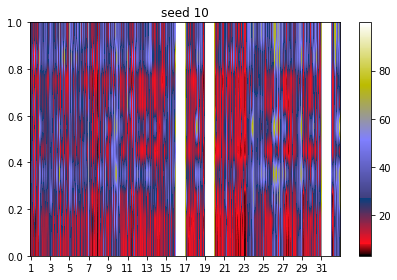

<Figure size 432x288 with 0 Axes>

In [20]:
plt.imshow(MNIST_NN_Std_prec_00001[4], cmap='gist_stern',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()
plt.savefig('linear_seed1000={}'.format(s))

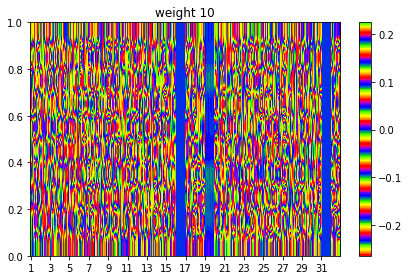

(array([[0., 0., 1., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 1., 0.],
        [0., 0., 0., ..., 2., 0., 0.],
        [0., 0., 0., ..., 1., 1., 0.]]),
 array([-0.26376882, -0.21498376, -0.16619872, -0.11741365, -0.0686286 ,
        -0.01984355,  0.02894151,  0.07772656,  0.12651162,  0.17529666,
         0.22408172], dtype=float32),
 <a list of 512 Lists of Patches objects>)

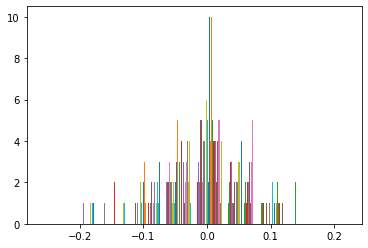

In [33]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        params = parameters

params_arr = params.detach().numpy()

plt.imshow(params_arr, cmap='prism',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('weight {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()
plt.hist(params_arr)